In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as dset
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, sampler
# from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

!pwd
root_dir = "."
print("The data lies here =>", root_dir)

We're using => cpu
/Users/michaeldu/Desktop/StanfordCS/cs231n/DeepAdDetection
The data lies here => .


In [72]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# data_path = './data-resized'
# train_dataset = dset.ImageFolder(
#     root=data_path,
#     transform=T.ToTensor()
# )
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=64,
#     num_workers=0,
#     shuffle=True
# )

NUM_TRAIN = 17245 #80/10/10


train = dset.ImageFolder(root='./data-new', transform=transform)
train_loader = DataLoader(train, batch_size=8, shuffle=False,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = dset.ImageFolder(root='./data-new', transform=transform)
val_loader = DataLoader(val, batch_size=1, shuffle=False,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 21557)))

test = dset.ImageFolder(root='./data-new', transform=transform)
test_loader = DataLoader(test, batch_size=1, shuffle=False,)

In [81]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}
train = datasets.ImageFolder(root ="./data-new",
                                      transform = image_transforms["train"]
                                     )
train_indices = list(range(len(train)))
np.random.shuffle(train_indices)
val_split_index = int(np.floor(0.2 * len(train)))
train_idx, val_idx = train_indices[val_split_index:], train_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=train, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=train, shuffle=False, batch_size=1, sampler=val_sampler)
# test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)

In [82]:
train.class_to_idx

{'ad': 0, 'not-ad': 1}

In [83]:
idx2class = {v: k for k, v in train.class_to_idx.items()}

In [31]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [32]:
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train), plot_title="Entire Dataset (before train/val/test split)")

KeyboardInterrupt: 

<Figure size 1080x576 with 0 Axes>

torch.Size([8, 3, 224, 224])
Output label tensors:  tensor([1, 1, 0, 1, 1, 1, 1, 1])

Output label tensor shape:  torch.Size([8])


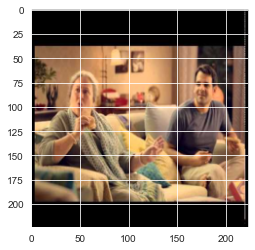

In [84]:
single_batch = next(iter(train_loader))

# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
print(single_batch[0].shape)

plt.imshow(single_image.permute(1, 2, 0))
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

In [37]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [38]:
model = classifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)

classifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [39]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [40]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [86]:
print("Begin training.")

for e in tqdm(range(1, 21)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


0.8937190175056458 50.0
1.514563262462616 112.0
2.2226656079292297 162.0
2.914191246032715 200.0
3.5749916434288025 262.0
4.140511751174927 350.0
4.6605188846588135 425.0
5.407936751842499 475.0


KeyboardInterrupt: 